 # LAB 7 MOS:  Simulación del Sistema de Torniquetes con SimPy

- Samuel Augusto Hernandez 202213772
- Tomas Alberto Rodriguez 2022128686

## Definición

La Universidad de los Andes estima un crecimiento del 28\% en la población estudiantil para el año 2025, lo que genera inquietudes sobre si la infraestructura de torniquetes del edificio SD (3 de entrada, 3 de salida; incluyendo 1 de entrada y 1 de salida con QR) podrá soportar la demanda. Especificaciones operativas:

- Tiempo de pase torniquete: $5 \pm 2$ s

- Preparación de carnet: $10 \pm 2$ s

- Lectura QR: $20 \pm 2$ s

## **Modelo Conceptual del Sistema**

### **Variables**

- Cola por torniquete: $Q_i =$ número de personas esperando en la cola del torniquete $i$

- Estado del torniquete: $S_i \in \{\text{ocupado}, \text{libre}\}$

- Persona: $m \in \{\text{carnet}, \text{QR}\},\ d \in \{\text{in}, \text{out}\},\ t =$ instante de llegada

### **Parámetros**

- Torniquetes: 3 de entrada y 3 de salida (1 para QR de cada uno)

- Tiempo de preparación de carnet: $10 \pm 2$ s

- Tiempo de lectura de QR: $20 \pm 2$ s

- Tiempo para pasar por el torniquete:  $5 \pm 2$ s

- Distribución del tiempo de llegada: modelada a partir de datos históricos

- Asignación de colas: 
  - Si $m = \text{QR}$, va al torniquete QR correspondiente
  - Si $m = \text{carnet}$, va al torniquete con menor longitud de cola


### **Métricas de Desempeño**

- Tiempo en cola: 
  $$
  T_{\text{cola}} = T_{\text{salida\_de\_cola}} - T_{\text{llegada}}
  $$

- Promedio de longitud de cola: 
  $$
  \overline{Q} = \frac{1}{T} \int_0^T Q(t)\ dt
  $$


### **Eventos**

#### **Llegada al edificio:**

##### **Acciones**

- Seleccionar torniquete i segun regla
- Si esta libre, hacer "Inicio de servicio"
- Si esta ocupado, entrar a la cola

#### **Inicio de servicio:**

##### **Acciones**

- Esperar tiempo segun caracteristicas
- Hacer "Fin de servicio"

#### **Fin de servicio:**

##### **Acciones**

- Registrar salida de persona
- Actualizar la cola del torniquete
- Si la cola pasa a estar vacia, actualizar su estado a libre
- Si la cola aun tiene personas, extraer una persona y hacer "Inicio de servicio"


## Instalacion  e importacion de librerias

In [3]:
!pip install fitter
!pip install pandas
!pip install numpy
!pip install matplotlib
!pip install scipy
!pip install simpy

In [4]:
import pandas as pd
import numpy as np
from fitter import Fitter, get_common_distributions
import matplotlib.pyplot as plt
from scipy.stats import rayleigh, lognorm, t
import simpy
import random
import seaborn as sns

## Carga de datos

In [5]:
# -------- parámetros --------
file_path = "SD Feb-May 2019.xlsx"           
sheets     = ["Feb-Mar", "Abr-May"] 

# -------- lectura --------
df_list = [pd.read_excel(file_path, sheet_name=s, engine="openpyxl") for s in sheets]
df = pd.concat(df_list)

df.index = pd.to_datetime(df['fecha_completa'], format='Y-%m-%d %H:%M:%S')

## Fase 1 Modelado de llegadas y salidas

In [6]:
df_filtered = (
        df.drop(columns=["PORTERIA", "RESULTADO_EVENTO", "ROL"])
        .query("MODO_ACCESO == 'Peatonal'")
        .drop(columns=["MODO_ACCESO"])
)
df_filtered["TIPO_ACCESO"] = df_filtered["TIPO_ACCESO"].str.strip()
df_filtered["DIA"] = pd.to_numeric(df_filtered["DIA"])
df_filtered.set_index(pd.to_datetime(df_filtered.index), inplace=True)

df_filtered.drop_duplicates(inplace=True)

df_filtered['day_of_week'] = df_filtered.index.day_name()

day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df_filtered['day_of_week'] = pd.Categorical(df_filtered['day_of_week'], categories=day_order, ordered=True)

df_filtered['week'] = df_filtered.index.isocalendar().week

df_filtered['time'] = df_filtered.index.time

# Separate Entries and Exits
df_in = df_filtered[df_filtered["TIPO_ACCESO"] == "IN"]
df_out = df_filtered[df_filtered["TIPO_ACCESO"] == "OUT"]

Por dia del mes

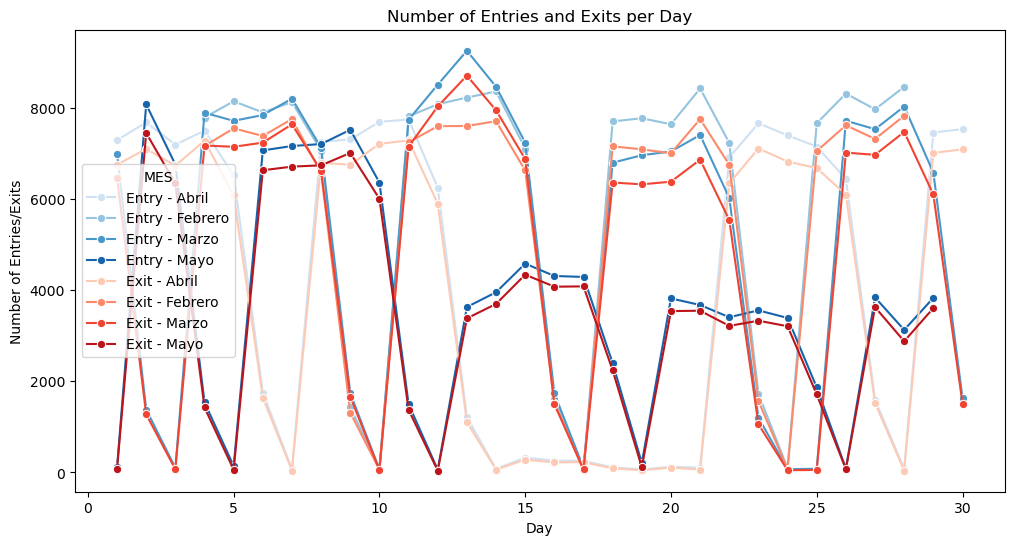

In [7]:
df_in_day = df_in.groupby(["MES", "DIA"]).size().reset_index(name="Entries")
df_out_day = df_out.groupby(["MES", "DIA"]).size().reset_index(name="Exits")

df_in_day['DAY'] = df_in_day['DIA']
df_out_day['DAY'] = df_out_day['DIA']

df_in_day['MES'] = "Entry - " + df_in_day['MES']
df_out_day['MES'] = "Exit - " + df_out_day['MES']

df_in_day = df_in_day.drop(columns=["DIA"])
df_out_day = df_out_day.drop(columns=["DIA"])

# Plotting
palette = {"Entries": sns.color_palette("Blues", 4), "Exits": sns.color_palette("Reds", 4)}
fig, ax = plt.subplots(figsize=(12, 6))

# Plot the entries it should plot the entries per day and diferentiate by a hue applied to the month
sns.lineplot(data=df_in_day, x="DAY", y="Entries", hue="MES", marker="o", palette=palette['Entries'], ax=ax)

# Plot the exits it should plot the exits per day and diferentiate by a hue applied to the month

sns.lineplot(data=df_out_day, x="DAY", y="Exits", hue="MES", marker="o", palette=palette['Exits'], ax=ax)

# Set the title of the plot

plt.title("Number of Entries and Exits per Day")

# Set the x-axis label
plt.xlabel("Day")

# Set the y-axis label
plt.ylabel("Number of Entries/Exits")
plt.show()

Por dia de la semana en intervalos de 5 minutos

/tmp/ipykernel_4163/937845871.py:7: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df_in_day = df_in[df_in['day_of_week'] == day].set_index('fecha_completa').resample('5T').size().reset_index(name='Entries')
/tmp/ipykernel_4163/937845871.py:8: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df_out_day = df_out[df_out['day_of_week'] == day].set_index('fecha_completa').resample('5T').size().reset_index(name='Exits')
/tmp/ipykernel_4163/937845871.py:7: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df_in_day = df_in[df_in['day_of_week'] == day].set_index('fecha_completa').resample('5T').size().reset_index(name='Entries')
/tmp/ipykernel_4163/937845871.py:8: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df_out_day = df_out[df_out['day_of_week'] == day].set_index('fecha_compl

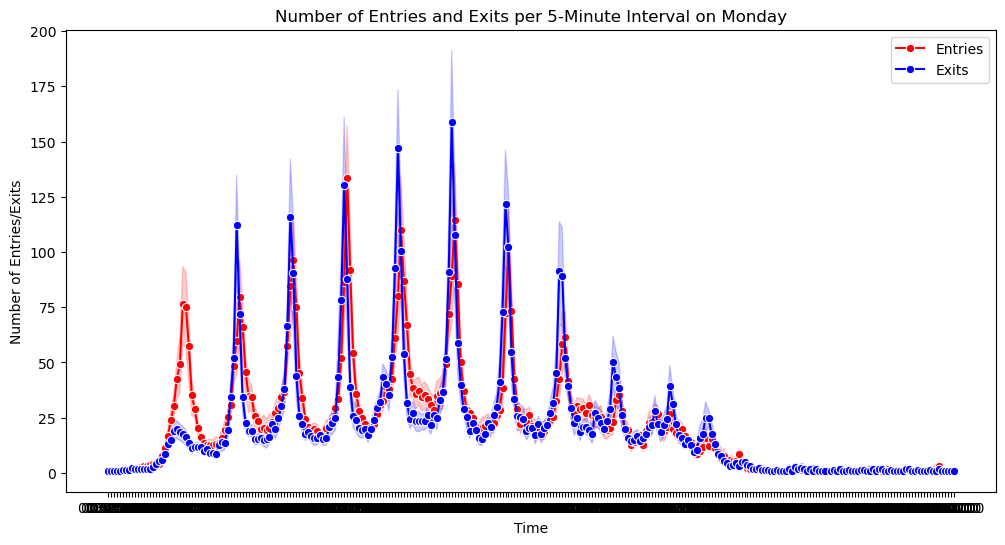

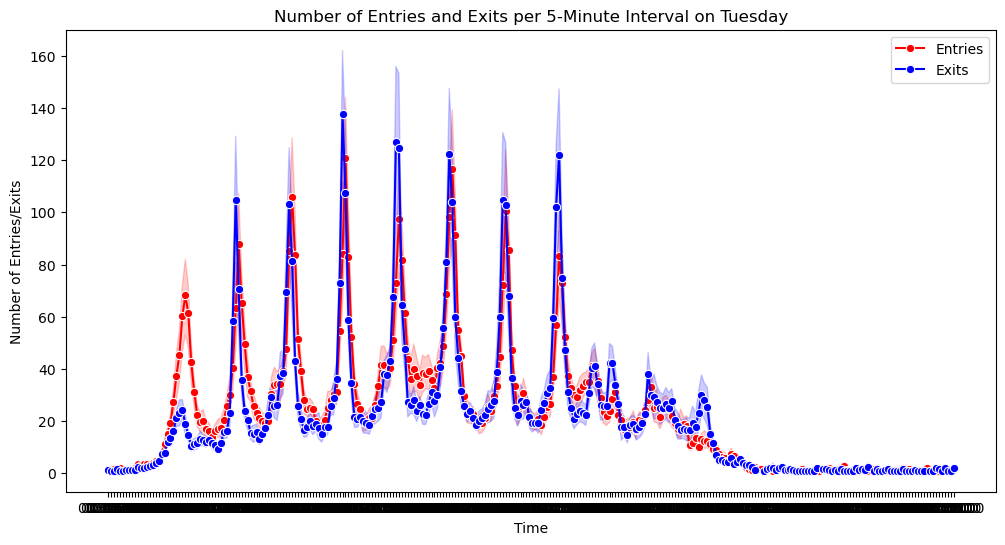

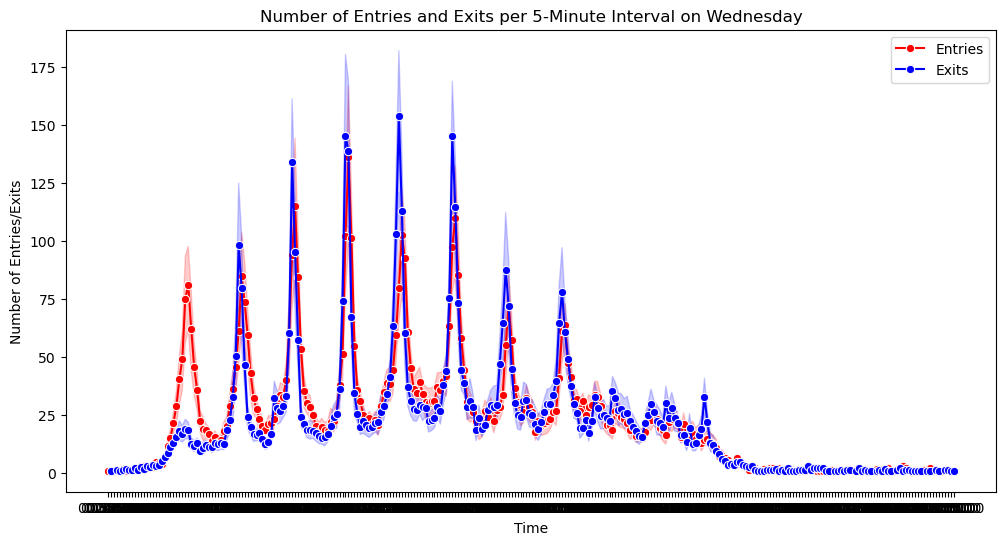

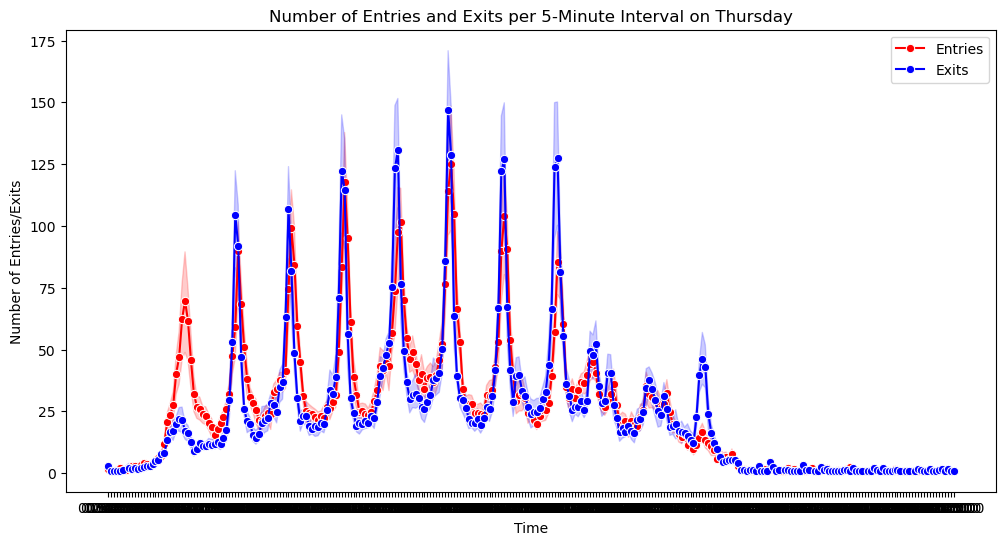

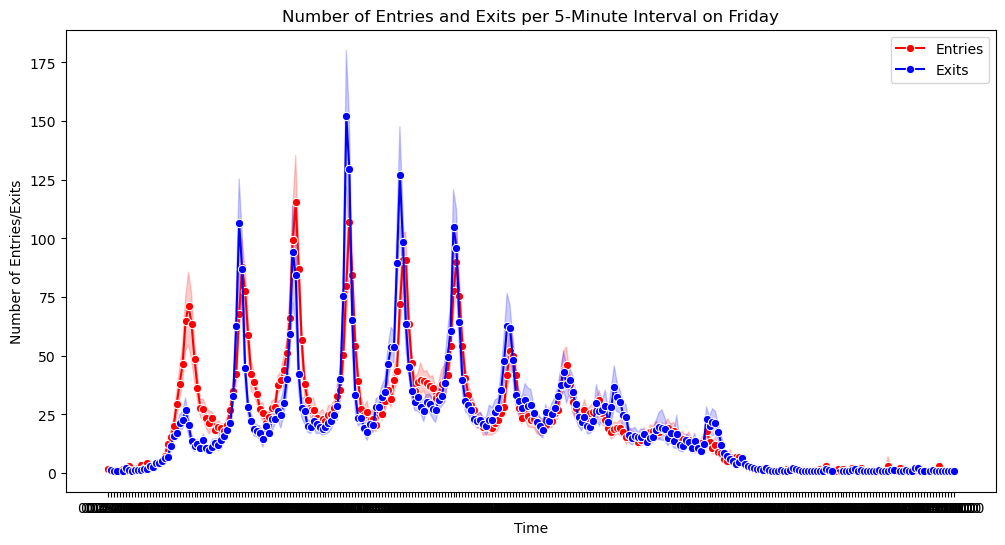

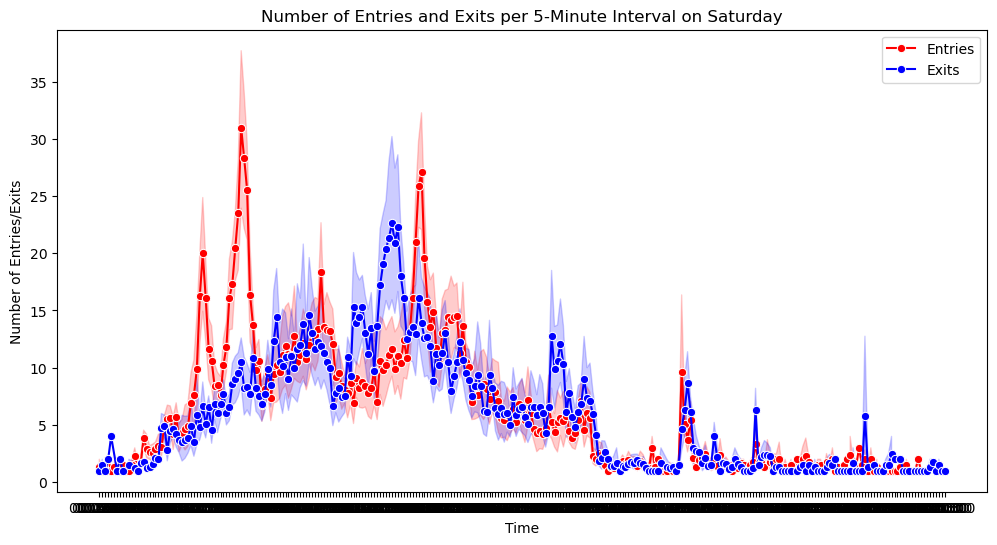

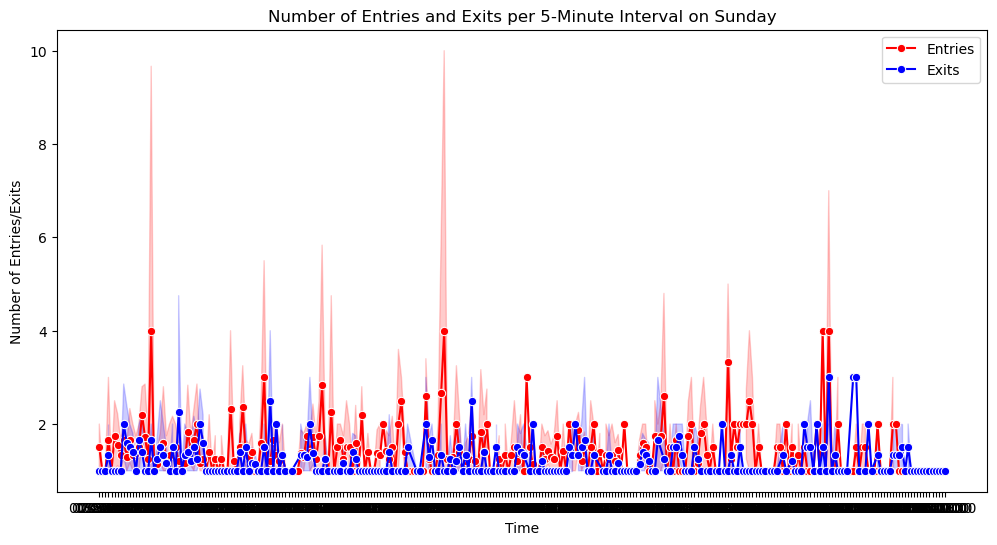

In [8]:
# Initialize dictionaries to hold DataFrames
df_in_5min = {}
df_out_5min = {}

# Group by 5-minute intervals for each day of the week
for day in df_in['day_of_week'].cat.categories:
        df_in_day = df_in[df_in['day_of_week'] == day].set_index('fecha_completa').resample('5T').size().reset_index(name='Entries')
        df_out_day = df_out[df_out['day_of_week'] == day].set_index('fecha_completa').resample('5T').size().reset_index(name='Exits')

        # Only keep non-zero entries
        df_in_day = df_in_day[df_in_day['Entries'] > 0]
        df_out_day = df_out_day[df_out_day['Exits'] > 0]

        df_in_day['time'] = df_in_day['fecha_completa'].dt.time.astype(str)
        df_out_day['time'] = df_out_day['fecha_completa'].dt.time.astype(str)

        df_in_day.set_index('time', inplace=True)
        df_out_day.set_index('time', inplace=True)

        df_in_5min[day] = df_in_day
        df_out_5min[day] = df_out_day

for day in df_in_5min.keys():
        fig, ax = plt.subplots(figsize=(12, 6))
        
        # Plot the entries per 5-minute interval
        sns.lineplot(data=df_in_5min[day], x=df_in_5min[day].index, y='Entries', marker='o', label='Entries', ax=ax, color='red')

        # Plot the exits per 5-minute interval
        sns.lineplot(data=df_out_5min[day], x=df_out_5min[day].index, y='Exits', marker='o', label='Exits', ax=ax, color='blue')

        # Set the title of the plot
        plt.title(f"Number of Entries and Exits per 5-Minute Interval on {day}")

        # Set the x-axis label
        plt.xlabel("Time")

        # Set the y-axis label
        plt.ylabel("Number of Entries/Exits")

        plt.legend()
        plt.show()

/tmp/ipykernel_4163/3497570491.py:13: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  .resample('1T')
/tmp/ipykernel_4163/3497570491.py:20: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  .resample('1T')
/tmp/ipykernel_4163/3497570491.py:13: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  .resample('1T')
/tmp/ipykernel_4163/3497570491.py:20: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  .resample('1T')
/tmp/ipykernel_4163/3497570491.py:13: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  .resample('1T')
/tmp/ipykernel_4163/3497570491.py:20: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  .resample('1T')
/tmp/ipykernel_4163/3497570491.py:13: FutureWarning: 'T' is depr

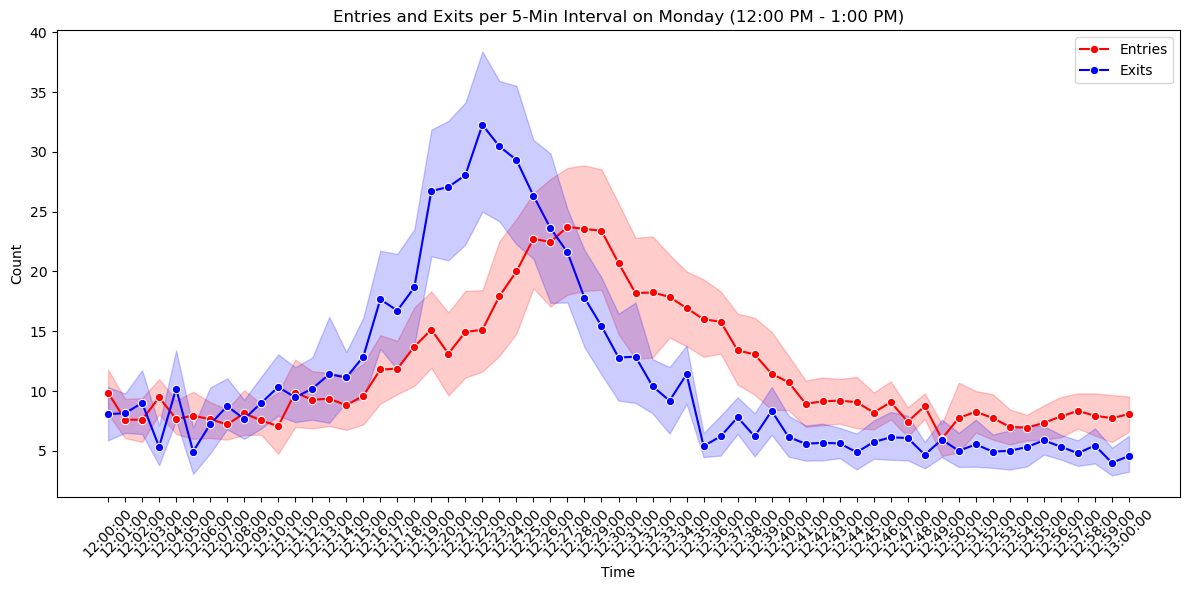

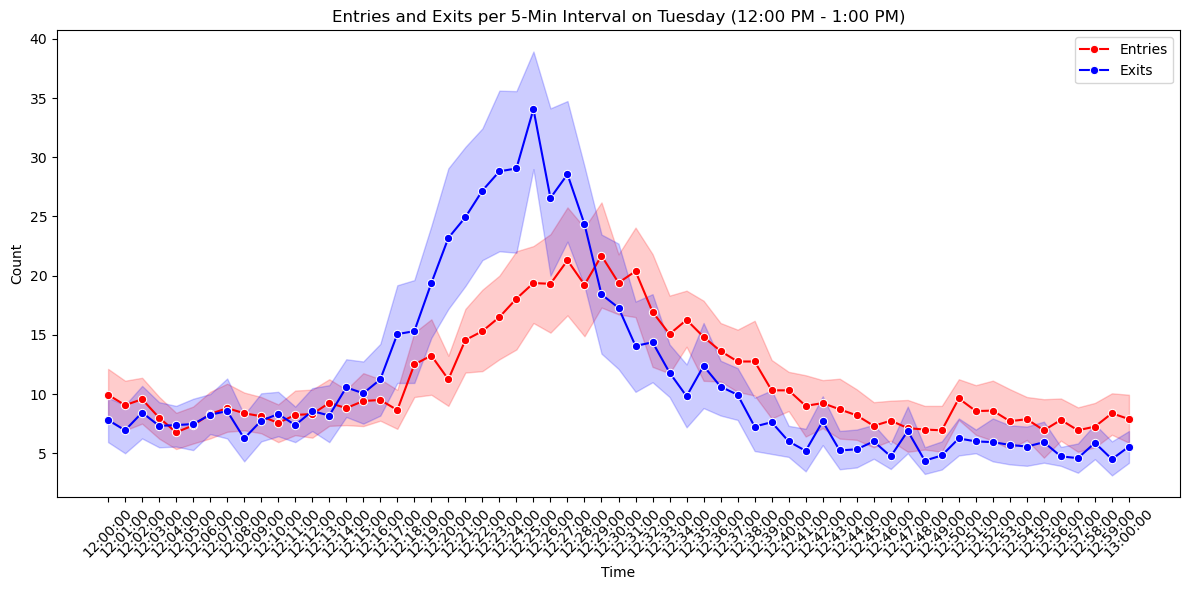

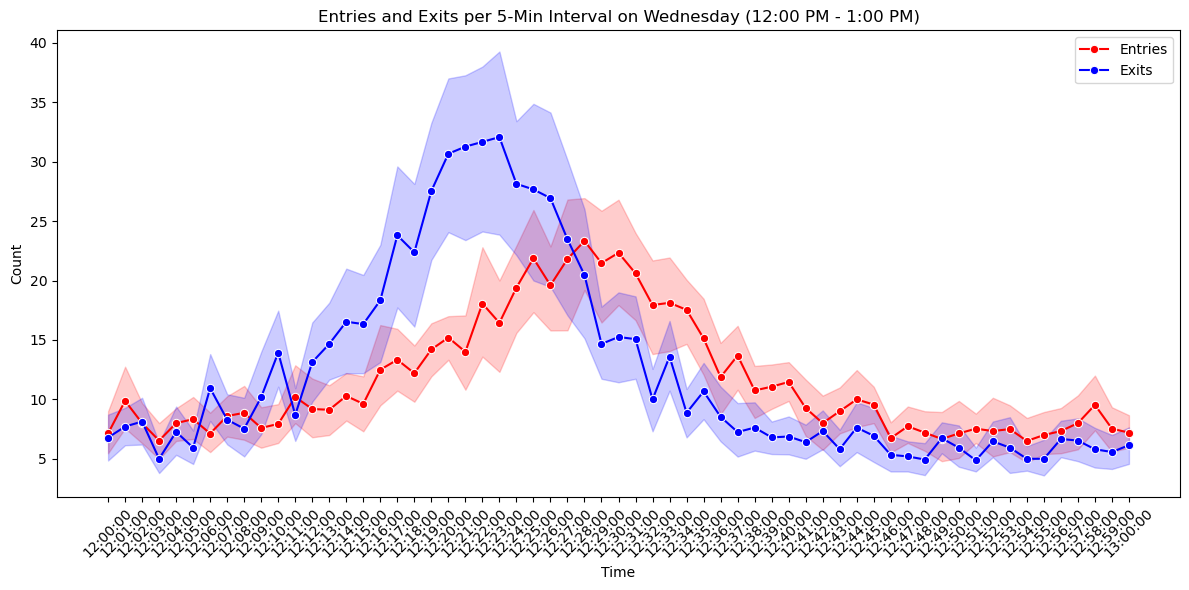

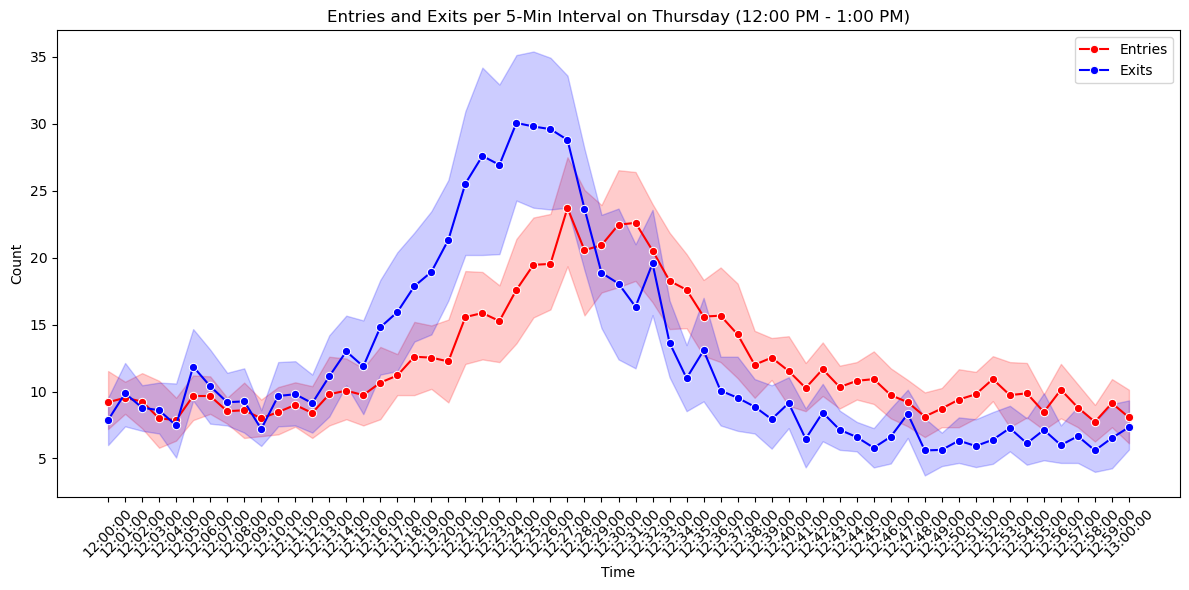

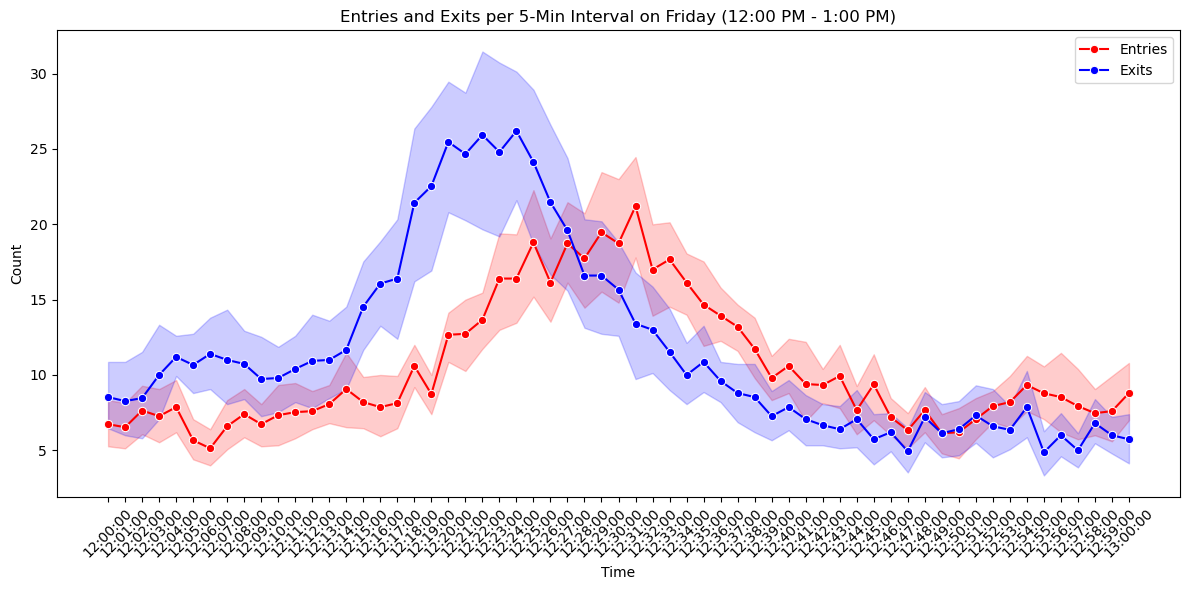

In [9]:
# Inicializar diccionarios
df_in_5min = {}
df_out_5min = {}

# Días a incluir (excluir sábado y domingo)
dias_validos = [d for d in df_in['day_of_week'].cat.categories if d not in ['Saturday', 'Sunday']]

# Agrupar por intervalos de 5 minutos por día de la semana
for day in dias_validos:
    df_in_day = (
        df_in[df_in['day_of_week'] == day]
        .set_index('fecha_completa')
        .resample('1T')
        .size()
        .reset_index(name='Entries')
    )
    df_out_day = (
        df_out[df_out['day_of_week'] == day]
        .set_index('fecha_completa')
        .resample('1T')
        .size()
        .reset_index(name='Exits')
    )

    # Filtrar entradas y salidas no nulas
    df_in_day = df_in_day[df_in_day['Entries'] > 0]
    df_out_day = df_out_day[df_out_day['Exits'] > 0]

    # Agregar columna de hora como string para indexar
    df_in_day['time'] = df_in_day['fecha_completa'].dt.time.astype(str)
    df_out_day['time'] = df_out_day['fecha_completa'].dt.time.astype(str)

    # Filtrar solo registros entre 12:00 y 13:00
    df_in_day = df_in_day[df_in_day['fecha_completa'].dt.time.between(pd.to_datetime("12:00").time(), pd.to_datetime("13:00").time())]
    df_out_day = df_out_day[df_out_day['fecha_completa'].dt.time.between(pd.to_datetime("12:00").time(), pd.to_datetime("13:00").time())]

    df_in_day.set_index('time', inplace=True)
    df_out_day.set_index('time', inplace=True)

    df_in_5min[day] = df_in_day
    df_out_5min[day] = df_out_day

# Graficar por cada día válido
for day in df_in_5min.keys():
    fig, ax = plt.subplots(figsize=(12, 6))
    
    sns.lineplot(data=df_in_5min[day], x=df_in_5min[day].index, y='Entries', marker='o', label='Entries', ax=ax, color='red')
    sns.lineplot(data=df_out_5min[day], x=df_out_5min[day].index, y='Exits', marker='o', label='Exits', ax=ax, color='blue')

    plt.title(f"Entries and Exits per 5-Min Interval on {day} (12:00 PM - 1:00 PM)")
    plt.xlabel("Time")
    plt.ylabel("Count")
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()


/tmp/ipykernel_4163/318176068.py:10: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  rango_tiempos = pd.date_range("12:00", "12:59", freq="1T").time
/tmp/ipykernel_4163/318176068.py:21: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  .resample('1T')
/tmp/ipykernel_4163/318176068.py:33: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  .resample('1T')
/tmp/ipykernel_4163/318176068.py:21: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  .resample('1T')
/tmp/ipykernel_4163/318176068.py:33: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  .resample('1T')
/tmp/ipykernel_4163/318176068.py:21: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  .resample('1T')
/tmp/ipykernel_4163/31

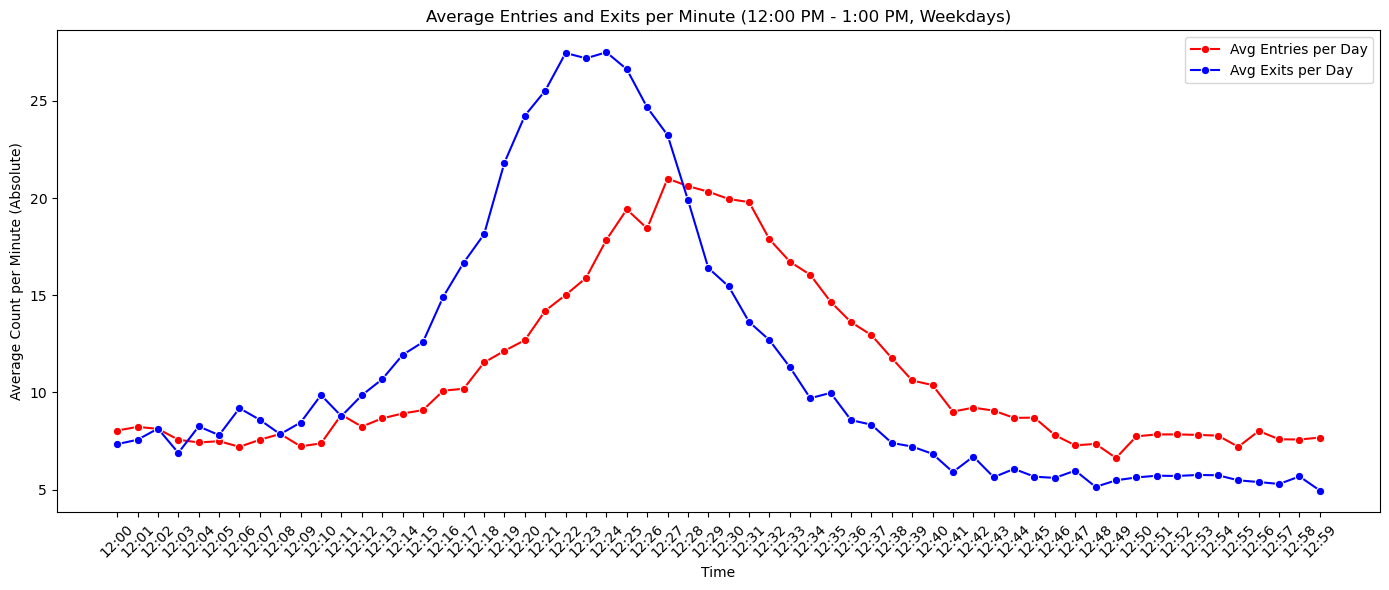

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Inicializar acumuladores
suma_entries = pd.Series(dtype=float)
suma_exits = pd.Series(dtype=float)

# Rango de tiempo esperado entre 12:00 y 13:00 en pasos de 1 minuto
rango_tiempos = pd.date_range("12:00", "12:59", freq="1T").time
rango_tiempos_str = [t.strftime("%H:%M:%S") for t in rango_tiempos]

# Días hábiles (excluyendo sábado y domingo)
dias_validos = [d for d in df_in['day_of_week'].cat.categories if d not in ['Saturday', 'Sunday']]

for day in dias_validos:
    # Entradas
    df_in_day = (
        df_in[df_in['day_of_week'] == day]
        .set_index('fecha_completa')
        .resample('1T')
        .size()
        .reset_index(name='Entries')
    )
    df_in_day = df_in_day[df_in_day['fecha_completa'].dt.time.between(pd.to_datetime("12:00").time(), pd.to_datetime("13:00").time())]
    df_in_day['time'] = df_in_day['fecha_completa'].dt.strftime('%H:%M:%S')
    df_in_day = df_in_day.groupby('time')['Entries'].sum()

    # Salidas
    df_out_day = (
        df_out[df_out['day_of_week'] == day]
        .set_index('fecha_completa')
        .resample('1T')
        .size()
        .reset_index(name='Exits')
    )
    df_out_day = df_out_day[df_out_day['fecha_completa'].dt.time.between(pd.to_datetime("12:00").time(), pd.to_datetime("13:00").time())]
    df_out_day['time'] = df_out_day['fecha_completa'].dt.strftime('%H:%M:%S')
    df_out_day = df_out_day.groupby('time')['Exits'].sum()

    # Rellenar con 0 donde falte tiempo
    entries = df_in_day.reindex(rango_tiempos_str, fill_value=0)
    exits = df_out_day.reindex(rango_tiempos_str, fill_value=0)

    # Acumular sumas
    suma_entries = suma_entries.add(entries, fill_value=0)
    suma_exits = suma_exits.add(exits, fill_value=0)

# Calcular la media (promedio por día)
n_dias = len(dias_validos)
promedio_entries = suma_entries / 80 if n_dias > 0 else suma_entries
promedio_exits = suma_exits / 80 if n_dias > 0 else suma_exits

# Crear DataFrame para graficar
df_media = pd.DataFrame({
    'Time': pd.to_datetime(promedio_entries.index, format='%H:%M:%S').strftime('%H:%M'),
    'Avg_Entries': promedio_entries.values,
    'Avg_Exits': promedio_exits.reindex(promedio_entries.index, fill_value=0).values
}).sort_values('Time')

# Graficar
plt.figure(figsize=(14, 6))
sns.lineplot(data=df_media, x='Time', y='Avg_Entries', label='Avg Entries per Day', marker='o', color='red')
sns.lineplot(data=df_media, x='Time', y='Avg_Exits', label='Avg Exits per Day', marker='o', color='blue')

plt.title('Average Entries and Exits per Minute (12:00 PM - 1:00 PM, Weekdays)')
plt.xlabel('Time')
plt.ylabel('Average Count per Minute (Absolute)')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()
